In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Ejercicio de clasificación - Clasificador Bayesiano Ingenuo
**Facundo A. Lucianna - Inteligencia Artificial - CEIA - FIUBA**

Vamos a aprender a aplicar un modelo de clasificación basado en el **Teorema de Bayes**, llamado **Naive Bayes**, mediante la biblioteca scikit-learn. Como vimos, este modelo se basa en dicho teorema, realizando una suposición muy importante: que las características (atributos) son independientes entre sí dado el valor de la clase. Esta es una simplificación fuerte que rara vez se cumple en la práctica, pero que permite construir modelos simples, rápidos y sorprendentemente eficaces en muchos escenarios.

Para este problema, vamos a utilizar un famoso dataset de reseñas de películas proveniente de [IMDb](https://www.imdb.com). Contiene 25.000 comentarios, los cuales pueden ser positivos o negativos con respecto a la película evaluada. Nuestro objetivo es poder predecir si un comentario es bueno o malo, a partir del texto. Este tipo de problema se denomina análisis de sentimiento (sentiment analysis). El dataset original lo pueden encontrar [aquí](https://ai.stanford.edu/~amaas/data/sentiment/)

Dado que los comentarios son texto libre y no tienen una estructura predefinida, necesitamos preprocesarlos antes de poder utilizarlos en un modelo. El preprocesamiento que se realizó aquí no se detalla, ya que será abordado en mayor profundidad en asignaturas futuras. Sin embargo, en términos generales, consistió en representar cada comentario según la frecuencia con la que aparecen las palabras que lo componen.

Este proceso se realizó utilizando una técnica llamada **TF-IDF (Term Frequency - Inverse Document Frequency)**, que asigna un peso a cada palabra en función de cuán frecuentemente aparece en un documento (TF - term frequency), pero también considerando cuán rara o común es esa palabra en el conjunto total de documentos (IDF - inverse document frequency). De esta manera, se da mayor importancia a las palabras que son distintivas de un comentario, y menor a aquellas que aparecen en todos los textos.

Además, durante el preprocesamiento se eliminaron las llamadas **stopwords**, que son palabras muy comunes en un idioma (como "el", "la", "y", "de", etc. en español o "the", "and", "is" en inglés) que no aportan valor significativo al análisis y sólo introducen ruido en el modelo.

El dataset ya preprocesado se encuentra guardado en forma tabular, con aproximadamente 28.000 atributos (uno por palabra) y una columna llamada `REVIEW_VALUE`, que es nuestra variable objetivo (label). Un valor de 1 indica que el comentario es positivo, y un valor de 0, que es negativo.

El archivo se encuentra en formato `parquet`, un tipo de formato de almacenamiento columnar optimizado para grandes volúmenes de datos. Parquet permite una lectura eficiente y un menor uso de espacio en disco, especialmente útil cuando se trabaja con conjuntos de datos grandes.

Vamos a leer el dataset utilizando la función `read_parquet()` de Pandas. Para ello, necesitamos instalar una dependencia opcional de Pandas llamada `pyarrow`. Si estamos trabajando en un entorno con conda, podemos hacerlo ejecutando:

```bash
conda install -y pyarrow
````

In [2]:
dataset = pd.read_parquet("./datasets/imbd_tfidf.parquet.gz")

In [3]:
print(f"Tamaño del dataset: {dataset.shape}")

Tamaño del dataset: (25000, 28897)


In [4]:
dataset.head()

,007,00s,01,010,02,05,06,07,10,100,...,zorro,zorros,zu,zucco,zucker,zuckerman,zulu,zuniga,émigré,REVIEW_VALUE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154871,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099351,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Veamos una descripción del conjunto de datos:

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 28897 entries, 007 to REVIEW_VALUE
dtypes: float64(28896), int64(1)
memory usage: 5.4 GB


Como tenemos tantos atributos, no se muestra la información detallada de cada columna. Todas las columnas son numéricas y no presentan valores faltantes. El dataset completo ocupa aproximadamente 5.4 GB en memoria, pero al estar almacenado en formato **parquet**, el archivo comprimido pesa solo 40 MB, lo que muestra el gran nivel de compresión que ofrece este formato.

> 🧠 **Nota:** Podríamos reducir aún más el uso de memoria si utilizáramos una representación esparsa, dado que hay una gran cantidad de ceros en la matriz TF-IDF.

Veamos cuántas observaciones hay de cada clase:

In [6]:
dataset["REVIEW_VALUE"].value_counts()

REVIEW_VALUE
1    12500
0    12500
Name: count, dtype: int64

Observamos que tenemos la misma cantidad de ejemplos positivos y negativos, por lo tanto, estamos frente a un problema balanceado.

Dado el gran número de atributos (palabras), no podemos hacer visualizaciones tradicionales, pero podemos analizar las palabras con mayor **TF-IDF** promedio para cada clase:

In [7]:
dataset_neg = dataset[dataset["REVIEW_VALUE"] == 0].drop(columns="REVIEW_VALUE")
dataset_pos = dataset[dataset["REVIEW_VALUE"] == 1].drop(columns="REVIEW_VALUE")

mean_tfidf_neg = dataset_neg.mean().sort_values(ascending=False)
mean_tfidf_pos = dataset_pos.mean().sort_values(ascending=False)

# Top 5 palabras con mayor TF-IDF promedio en cada clase
print("🔴 Palabras más representativas de la clase NEGATIVA:")
print(mean_tfidf_neg.head(5))

print("\n🟢 Palabras más representativas de la clase POSITIVA:")
print(mean_tfidf_pos.head(5))

del mean_tfidf_neg, mean_tfidf_pos

🔴 Palabras más representativas de la clase NEGATIVA:
movie    0.054885
film     0.038794
bad      0.026753
like     0.026248
good     0.020676
dtype: float64

🟢 Palabras más representativas de la clase POSITIVA:
movie    0.042562
film     0.040738
great    0.021882
good     0.020862
like     0.020536
dtype: float64


Se observa que algunas palabras con alto **TF-IDF** aparecen en ambas clases, como por ejemplo `good`, pero también hay términos distintivos como `bad` en las negativas y `great` en las positivas. Analicemos la distribución de estas palabras:

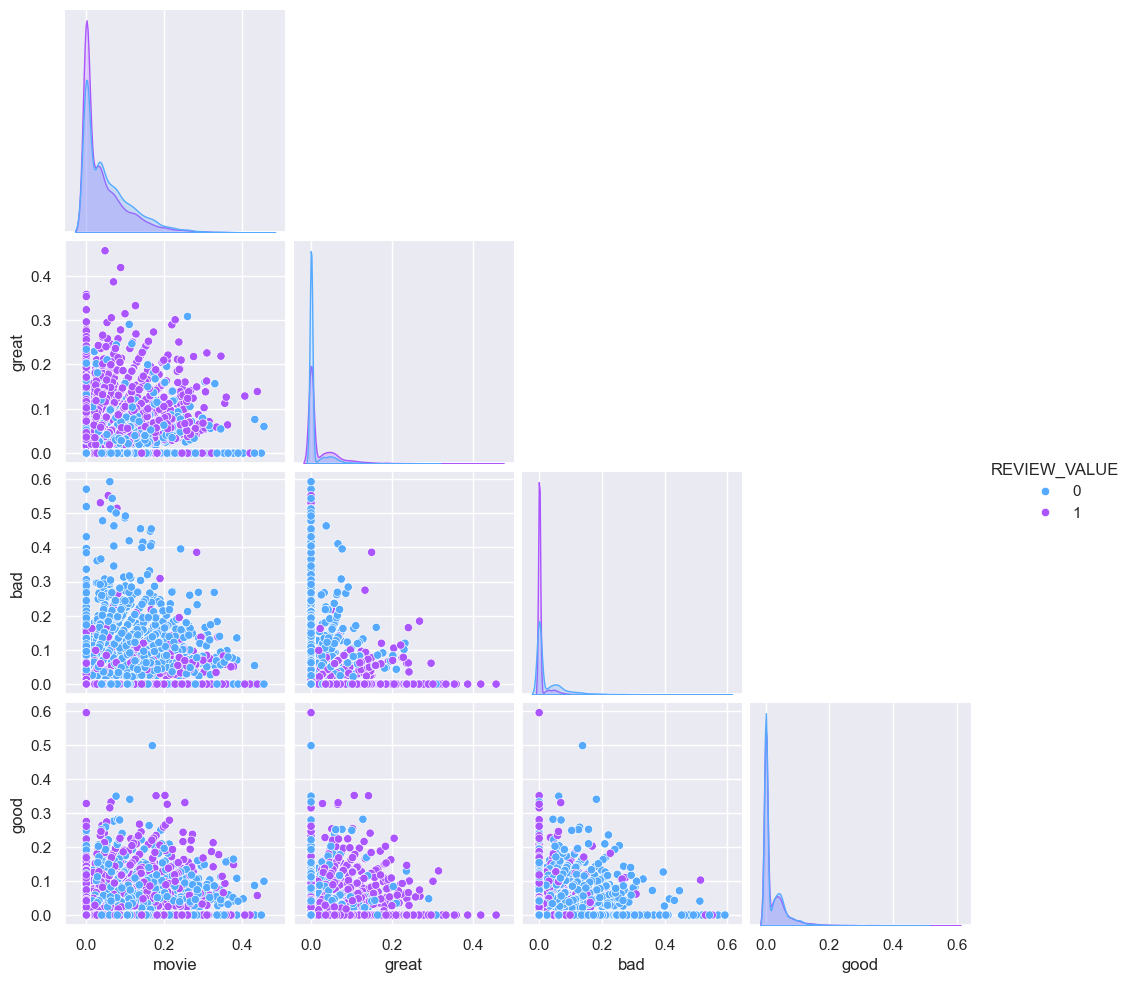

In [8]:
col_sel = ["movie", "great", "bad", "good", "REVIEW_VALUE"]
dataset_visualization = dataset[col_sel]

sns.pairplot(data=dataset_visualization, diag_kind="kde", hue="REVIEW_VALUE", palette="cool", corner=True);

La distribución es mucho más compleja de visualizar que, por ejemplo, en el clásico dataset de Iris: hay mucha superposición entre clases. Sin embargo, llama la atención cómo se separan las clases en dimensiones como `great` vs `bad`.

## Clasificador Bayesiano Ingenuo

Apliquemos un modelo Naive Bayes, pero antes veamos qué opciones nos ofrece la documentación oficial de [**scikit-learn**](https://scikit-learn.org/stable/api/sklearn.naive_bayes.html):

- **BernoulliNB**: Utiliza variables binarias (presencia o ausencia de características), ideal cuando los datos son de tipo binario, como en el caso de la presencia/ausencia de palabras en texto.
- **CategoricalNB**: Se utiliza para datos categóricos, donde las características son discretas y tienen más de dos posibles valores, común en datos no numéricos.
- **MultinomialNB**: Ideal para datos discretos como conteos de palabras en texto, especialmente cuando las características tienen más de dos valores posibles y están basadas en frecuencias.
- **ComplementNB**: Variante de *MultinomialNB* que mejora el rendimiento en conjuntos de datos desbalanceados, ajustando las probabilidades de las clases complementarias para compensar el sesgo.
- **GaussianNB**: Asume que las características siguen una distribución normal (gaussiana) continua, siendo útil cuando las variables son continuas y tienen una forma aproximadamente normal.

Para nuestro caso, vamos a usar [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB), ya que estamos trabajando con TF-IDF.

In [9]:
from sklearn.naive_bayes import MultinomialNB

*Una posible duda que puede surgir es: ¿no estamos usando demasiados atributos? ¿No vamos a tener overfitting?*

Este modelo, por su simplicidad, es menos propenso al overfitting, pero vamos a comprobarlo. Para ello, aplicaremos una validación utilizando el conjunto de entrenamiento, y evaluaremos con la métrica `accuracy`, ya que tenemos un problema balanceado.

In [10]:
from sklearn.model_selection import train_test_split

# División en variables independientes y target
X = dataset.drop(columns=["REVIEW_VALUE"])
y = dataset["REVIEW_VALUE"]

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Separar un set de validación dentro del entrenamiento
X_train_temp, X_val, y_train_temp, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

Entrenamos el modelo y comparamos rendimiento entre entrenamiento y validación:

In [11]:
model = MultinomialNB()

model.fit(X_train_temp, y_train_temp)
accuracy_train = model.score(X_train_temp, y_train_temp)
accuracy_validation = model.score(X_val, y_val)

print(f"La exactitud de entrenamiento es {accuracy_train}")
print(f"La exactitud de validación es {accuracy_validation}")

del X_train_temp, y_train_temp, X_val, y_val

La exactitud de entrenamiento es 0.9136507936507936
La exactitud de validación es 0.8685714285714285


Vemos que ambos scores son **altos y similares** entre sí, lo que indica que no hay *overfitting* ni *underfitting*. El modelo parece generalizar bien, por lo que procedemos a entrenarlo con el conjunto completo de entrenamiento:

In [12]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

### Evaluación

Evaluamos al modelo utilizando las mismas métricas vistas anteriormente:

In [13]:
y_pred = model.predict(X_test)

In [14]:
from sklearn.metrics import confusion_matrix

def sens_spec(cm):
    sensitivity = cm[1, 1] / np.sum(cm[1, :])
    specifity = cm[0, 0] / np.sum(cm[0, :])
    balanced_accuracy = (sensitivity + specifity) / 2

    return sensitivity, specifity, balanced_accuracy

cm = confusion_matrix(y_test, y_pred)
sensitivity, specifity, balanced_accuracy = sens_spec(cm)

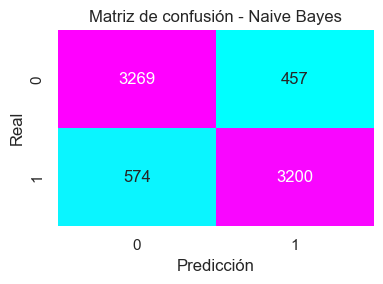

In [15]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=False)

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Naive Bayes")

plt.tight_layout()
plt.show()

In [16]:
print(f"Sensibilidad: {sensitivity}")
print(f"Especificidad: {specifity}")
print(f"Exactitud balanceada: {balanced_accuracy}")

Sensibilidad: 0.8479067302596714
Especificidad: 0.8773483628556092
Exactitud balanceada: 0.8626275465576403


El modelo muestra un rendimiento general muy bueno, con exactitudes elevadas. La matriz de confusión revela un comportamiento bastante simétrico en los errores, lo cual también se refleja en las métricas de sensibilidad y especificidad.

Veamos ahora el reporte de clasificación completo:

In [17]:
from sklearn.metrics import classification_report

target_names = ["Negativo", "Positivo"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negativo       0.85      0.88      0.86      3726
    Positivo       0.88      0.85      0.86      3774

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



Veamos también la **curva ROC**:

In [18]:
p_pred = model.predict_proba(X_test)

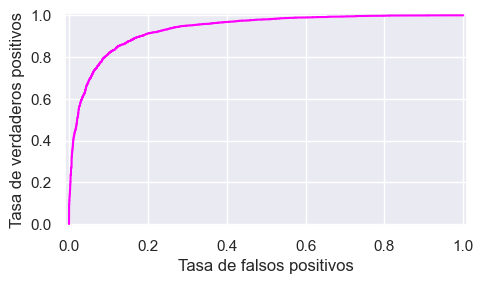

In [19]:
from sklearn.metrics import roc_curve

colors = ["#00FFFF", "#FF00FF", "#FF1493", "#00BFFF", "#FF6347"]

fpr, tpr, thr = roc_curve(y_test, p_pred[:, 1])

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color=colors[1])
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.tight_layout();

Y finalmente, el **AUC (Área Bajo la Curva ROC)**:

In [20]:
from sklearn.metrics import roc_auc_score

print(f"AUC: {roc_auc_score(y_test, p_pred[:, 1])}\n")

AUC: 0.9343722096634854



Las métricas obtenidas indican que el modelo generaliza correctamente y logra un rendimiento excelente.
Recordemos que estamos utilizando un modelo muy simple, basado en el **Teorema de Bayes**, que solo calcula y multiplica probabilidades.

La clave del éxito está en los **datos**: el preprocesamiento aplicado al texto (TF-IDF + eliminación de stopwords) permite representar el contenido de manera eficaz, facilitando el trabajo del clasificador. No sean impacientes en aprender esto, ya van a ver este tema durante la carrera.

Naive Bayes es una excelente opción para problemas asociados a texto, como en este caso de análisis de sentimientos. También se utiliza frecuentemente en tareas como la detección de SPAM, clasificación de correos electrónicos, análisis de temas, y sistemas de recomendación de contenido textual.